# Q1
(a) generate data from two classes as following:
- X1 = samp1(n)
- X2 = samp2(n)

choose n to be 50

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

# animations
import matplotlib.animation as anim
from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG


def noise_samples(samples, required_sample_num, random_gen=np.random.normal, params=dict(loc=0.0, scale=0.2)):
    """
    return required_sample_num sample by creating "noised" data around the original samples
    :param samples: original samples
    :param required_sample_num: number of samples needed
    :param random_gen: random generator. default np.random.normal
    :param params: parameters for random generator. default loc (mean) = 0.0 and scale (std) = 0.2
    """
    delta_sample_num = required_sample_num - samples.shape[0]
    assert delta_sample_num > 0
    centers = samples[np.random.choice(samples.shape[0], delta_sample_num, True)]
    params.update(dict(size=(delta_sample_num, samples.shape[1])))
    random_samples = centers + random_gen(**params)
    return np.vstack((samples, random_samples))

def samp1(n):
    """
    return n 2D samples from class 1
    :param n: number of samples
    :returns X: an ndarray with shape (n, 2)
    """
    m = np.array([
        [0.8, 1],
        [0.5, 2],
        [2.2, 3.3],
        [3, 5],
        [3.4, 4.2],
        [3.4, 1.9]
    ])
    return noise_samples(m, n)


def samp2(n):
    """
    return n 2D samples from class 2
    :param n: number of samples
    :returns X: an ndarray with shape (n, 2)
    """
    m = np.array([
        [1.5, 0.5],
        [1.7, 2.2],
        [2.3, 2],
        [4.3, 2.1],
        [4.3, 4.6],
    ])
    return noise_samples(m, n)



In [24]:
n = 50
X1 = samp1(n)
X2 = samp2(n)

(b) draw scatter plot of X1 and X2 and mark them by different colors

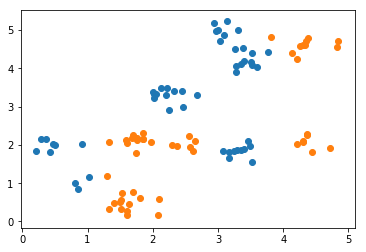

In [25]:
plt.scatter(X1[:,0], X1[:,1])
plt.scatter(X2[:,0], X2[:,1])
plt.show()

(c) create vectors of labels for X1 and X2 (Y1, Y2 respectively) using np.ones((n)) and -np.ones((n))

In [26]:
Y1 = np.ones(n)
Y2 = -np.ones(n)

(d) create data matrix X by vertically concatenating X1 and X2. create label vector Y by horizontally concatenating Y1 and Y2.

In [27]:
X = np.append(X1, X2, axis=0)
Y = np.append(Y1, Y2)

(e) call function train_lin_classifier with arguments X and Y to get a axis aligned linear classifier.

In [28]:
def train_axis_aligned_lin_classifier(X_, Y_, weights=None, show_graph=False):
    """
    axis aligned linear classifier parallel to either the of the axes
    :param X_: data - numpy array (n_samples, n_features)
    :param Y_: labels - numpy array (n_samples, )
    :param weights: sample weights - numpy array (n_samples, )
    :returns w: coefficient - numpy array (n_features, 1)
    :returns b: intercept - scalar
    """
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(X_, Y_, sample_weight=weights)
    w = np.zeros((2, 1))
    w[clf.tree_.feature[0]] = 1
    b = -clf.tree_.threshold[0]
    
    if show_graph:
        graph = Source(export_graphviz(clf, out_file=None))
        display(SVG(graph.pipe(format='svg')))
    
    return w, b

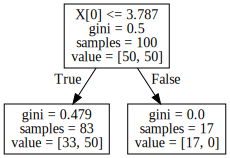

[[1.]
 [0.]] -3.78698468208313


In [29]:
w, intercept = train_axis_aligned_lin_classifier(X, Y, show_graph=True)
print(w, intercept)

(f) in the next cell you will find a plotting function for binary classification results
- add an informative title including the fraction of correct prediction to all predictions i.e. accuracy
- complete the required classification function using the results from traing the axis aligned linear classifier
- run the cell and observe the results


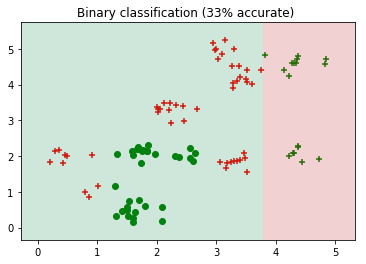

In [30]:
# meshgrid for plotting decision function
h = .02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
zz = np.c_[xx.ravel(), yy.ravel()]

# write classification function here
def class_fun(data):
    return np.sign((data @ w) + intercept).ravel()

def show_results(X, Y, classification_fun, title_suffix='', show=True):
    y_predict = classification_fun(X)
        
    hits = (y_predict == Y)
    x1_hits = (Y==1)*hits
    x1_misses = (Y==1)*(hits==False)
    x2_hits = (Y==-1)*hits
    x2_misses = (Y==-1)*(hits==False)
    
    plt.scatter(X[x1_hits, 0], X[x1_hits, 1], c='r', marker='o')
    plt.scatter(X[x1_misses, 0], X[x1_misses, 1], c='r', marker='+')
    plt.scatter(X[x2_hits, 0], X[x2_hits, 1], c='g', marker='o')
    plt.scatter(X[x2_misses, 0], X[x2_misses, 1], c='g', marker='+')
    plt.contourf(xx, yy, classification_fun(zz).reshape(xx.shape), cmap=plt.cm.RdYlGn_r, alpha=0.2)

    # add title here
    plt.title("Binary classification (%d%% accurate) %s" % ((100*(Y == y_predict).sum()/len(Y)), title_suffix))
    if show:
        plt.show()

show_results(X, Y, class_fun, show=True)


# Q2
(a) implement bagging for the scenario described in question 1. try bagging with different numbers of bootstrap samples. plot scatter plots of your results

In [31]:
# implement bagging function
def boostrap_aggregating(X_, Y_, n_samples):
    bag_X = np.zeros((n_samples, X_.shape[1]))
    bag_Y = np.zeros((n_samples, 1))
    total_samples = X_.shape[0]

    for idx in range(n_samples):
        sample_idx = random.randint(0, total_samples-1)
        bag_X[idx], bag_Y[idx] = X_[sample_idx], Y_[sample_idx]
        
    bag_Y = bag_Y.ravel()

    w, intercept = train_axis_aligned_lin_classifier(bag_X, bag_Y)
    intercept = np.array([intercept])
            
    return w, intercept

50 iterations


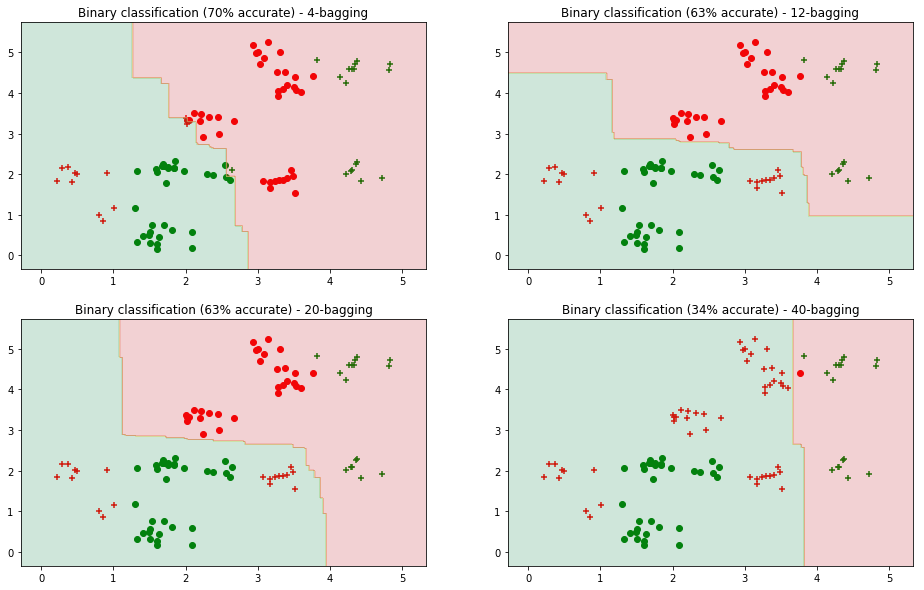

In [32]:
def bag_class_fun(data):
    y_pred = ((np.sign((data @ w_bag) + intercept_bag).sum(axis=1)/len(intercept_bag) >=0)-0.5)*2
    return y_pred

def add_bagging_classifier(X_, Y_, sample_size):
    global w_bag, intercept_bag
    w_, intercept_ = boostrap_aggregating(X_, Y_, sample_size)
    if w_bag is None:
        w_bag = w_
        intercept_bag = intercept_
    else:
        w_bag = np.append(w_bag, w_, axis=1)
        intercept_bag = np.append(intercept_bag, intercept_, axis=0)
    
plt.subplots(2,2, figsize=(16, 10))

n_iterations = 50

# 4 elements
n_elements = 4
w_bag, intercept_bag = None, None
plt.subplot(2, 2, 1)
for i in range(1, n_iterations):
    add_bagging_classifier(X, Y, n_elements)
show_results(X, Y, bag_class_fun, '- %d-bagging' % n_elements, show=False)

# 12 elements
n_elements = 12
w_bag, intercept_bag = None, None
plt.subplot(2, 2, 2)
for i in range(1, n_iterations):
    add_bagging_classifier(X, Y, n_elements)
show_results(X, Y, bag_class_fun, '- %d-bagging' % n_elements, show=False)

# 20 elements
n_elements = 20
w_bag, intercept_bag = None, None
plt.subplot(2, 2, 3)
for i in range(1, n_iterations):
    add_bagging_classifier(X, Y, n_elements)
show_results(X, Y, bag_class_fun, '- %d-bagging' % n_elements, show=False)

# 40 elements
n_elements = 40
w_bag, intercept_bag = None, None
plt.subplot(2, 2, 4)
for i in range(1, n_iterations):
    add_bagging_classifier(X, Y, n_elements)
show_results(X, Y, bag_class_fun, '- %d-bagging' % n_elements, show=False)

print('%d iterations' % n_iterations)
plt.show()

(b) implement AdaBoost for the scenario described in question 1. try AdaBoost with different numbers of base classifiers. plot scatter plots of your results.

In [11]:
def train_ada_boost(X_, Y_, n_classifiers):
    global weights_ada, w_ada, intercept_ada, alpha_ada, w, intercept
    # 1. Init Variables
    weights_ada = np.ones(X_.shape[0]) * 1/X_.shape[0]
    alpha_ada = np.zeros(n_classifiers)
    w_ada = None
    intercept_ada = None

    # 2. Iterate through n classifiers
    for i in range(n_classifiers):
        # 2.1. Fit model and save it to global variables
        w, intercept = train_axis_aligned_lin_classifier(X_, Y_, weights_ada)
        if w_ada is None:
            w_ada = w
            intercept_ada = np.array([intercept])
        else:
            w_ada = np.append(w_ada, w, axis=1)
            intercept_ada = np.append(intercept_ada, np.array([intercept]), axis=0)

        # 2.2 Calculate Error
        y_predict = class_fun(X_)
        err = ((y_predict != Y_) * weights_ada).sum() / weights_ada.sum()

        # 2.3 Calculate alpha
        alpha_ada[i] = np.log((1-err)/err) / 2

        # 2.4 Update weights
        weights_ada *= np.exp(-alpha_ada[i] * Y_ * y_predict)

        # 2.5 Normalize weights
        weights_ada /= weights_ada.sum()

def predict_ada_boost(X_):
    global w_ada, intercept_ada, alpha_ada
    return np.sign(np.sign((X_ @ w_ada) + intercept_ada) @ alpha_ada)

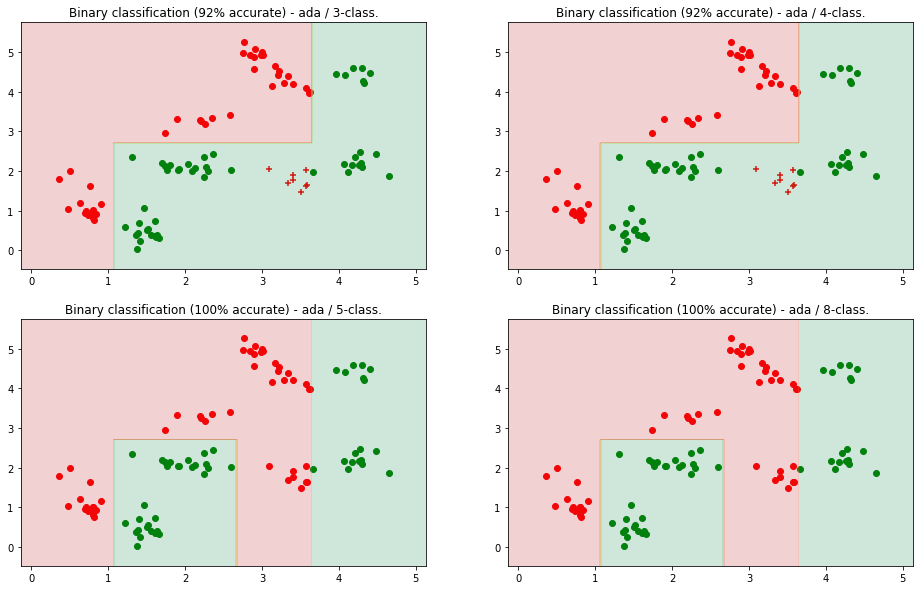

In [17]:
# run with different numbers of base classifiers
plt.subplots(2,2, figsize=(16, 10))

# 5 base classifiers
n_classifiers = 3
plt.subplot(2, 2, 1)
train_ada_boost(X, Y, n_classifiers)
show_results(X, Y, predict_ada_boost, '- ada / %d-class.' % n_classifiers, show=False)

# 20 base classifiers
n_classifiers = 4
plt.subplot(2, 2, 2)
train_ada_boost(X, Y, n_classifiers)
show_results(X, Y, predict_ada_boost, '- ada / %d-class.' % n_classifiers, show=False)

# 50 base classifiers
n_classifiers = 5
plt.subplot(2, 2, 3)
train_ada_boost(X, Y, n_classifiers)
show_results(X, Y, predict_ada_boost, '- ada / %d-class.' % n_classifiers, show=False)

# 100 base classifiers
n_classifiers = 8
plt.subplot(2, 2, 4)
train_ada_boost(X, Y, n_classifiers)
show_results(X, Y, predict_ada_boost, '- ada / %d-class.' % n_classifiers, show=False)

plt.show()

# Q3
(a) whats wrong with the learning procedure we performed in question 1?

<font color='blue'>In Q1 we trained a binary tree and output its decision threshold and over which axis the decision is made, but the output didn't reflect which class is on each side of the intercept. 

In Q1 the output was 31% which is non-sensical for a decision tree for which the worse possible classification over the training set has to be 50%/50%.</font>

(b) [bonus] why is this violation not as severe for the procedure you performed in question 2.a?

<font color='blue'>In question 2.a because we averaged the results of sub-samples the barrier moved towards a 50/50 classification, so this mitigated this effect. Also, because bagging is performed on sub-samples, it is more likely that some models will perform the correct clssification (e.g. if the most green samples happen to be on the left of the intercept for a given sub-sample), which also helps producing an average classification.

But this also means that had we performed bagging with the right learning procedure, the results would have been worse when predicting the training set than without bagging.</font>

(c) can you tell what is the ideal number of base classifiers for boosting in this case? do you need to specify it in advance?

<font color='blue'>The ideal number in this case is 5 because it is the smallest number that successfully classifies all points in the training set (100% accuracy)</font>

(d) can you suggest a modification to bagging to make it perform better in this case? explain your idea, implement your suggestion and plot the results.

<font color='blue'>For each classifier we train during the bagging we will keep track of whether it is reversed or not, and update the predict function accordingly.</font>

In [13]:
# bagging function - fixed
def boostrap_aggregating_fixed(X_, Y_, n_samples):
    bag_X = np.zeros((n_samples, X_.shape[1]))
    bag_Y = np.zeros((n_samples, 1))
    total_samples = X_.shape[0]

    for idx in range(n_samples):
        sample_idx = random.randint(0, total_samples-1)
        bag_X[idx], bag_Y[idx] = X_[sample_idx], Y_[sample_idx]
        
    bag_Y = bag_Y.ravel()

    w, intercept = train_axis_aligned_lin_classifier(bag_X, bag_Y)
    intercept = np.array([intercept])    
    reversed_class = np.sign((bag_class_fun(bag_X) == bag_Y).sum()/bag_X.shape[0] - 0.5)
    reversed_class = np.array([reversed_class]) if reversed_class != 0 else np.array([-1])
    
    return w, intercept, reversed_class

def bag_class_fun_fixed(data):
    y_pred = ((np.sign(((data @ w_bag) + intercept_bag) * reversed_class_bag).sum(axis=1)/len(intercept_bag) >=0)-0.5)*2
    
    return y_pred

def add_bagging_classifier_fixed(X_, Y_, sample_size):
    global w_bag, intercept_bag, reversed_class_bag
    w_, intercept_, reversed_class_ = boostrap_aggregating_fixed(X_, Y_, sample_size)
    w_bag = np.append(w_bag, w_, axis=1)
    intercept_bag = np.append(intercept_bag, intercept_, axis=0)
    reversed_class_bag = np.append(reversed_class_bag, reversed_class_, axis=0)
    

200 iterations


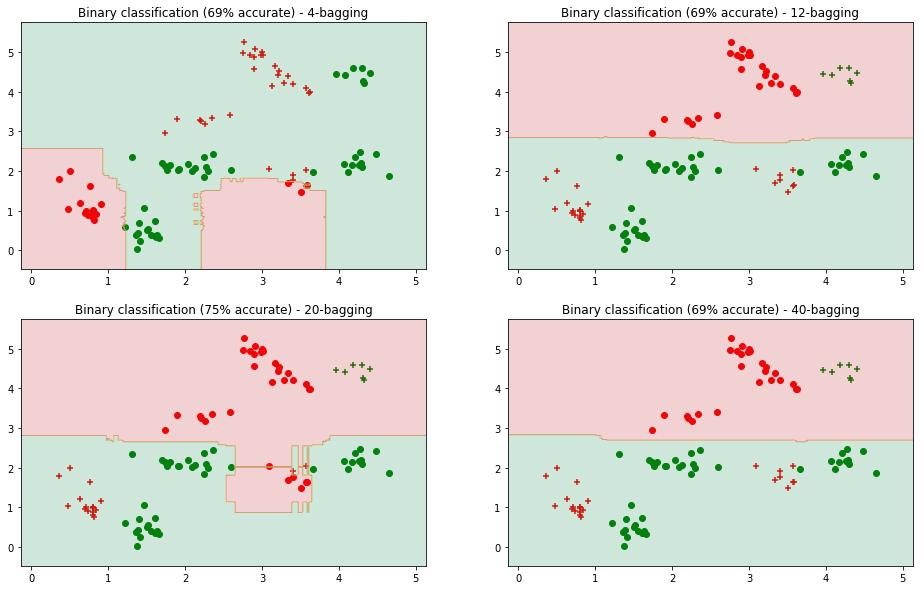

In [14]:
# run and plot results
plt.subplots(2,2, figsize=(16, 10))

n_iterations = 200

# 4 elements
w_bag, intercept_bag, reversed_class_bag = boostrap_aggregating_fixed(X, Y, 4)
for i in range(0, n_iterations):
    add_bagging_classifier_fixed(X, Y, 4)
plt.subplot(2, 2, 1)
show_results(X, Y, bag_class_fun_fixed, '- 4-bagging', show=False)

# 12 elements
w_bag, intercept_bag, reversed_class_bag = boostrap_aggregating_fixed(X, Y, 12)
for i in range(0, n_iterations):
    add_bagging_classifier_fixed(X, Y, 12)
plt.subplot(2, 2, 2)
show_results(X, Y, bag_class_fun_fixed, '- 12-bagging', show=False)

# 20 elements
w_bag, intercept_bag, reversed_class_bag = boostrap_aggregating_fixed(X, Y, 20)
for i in range(0, n_iterations):
    add_bagging_classifier_fixed(X, Y, 20)
plt.subplot(2, 2, 3)
show_results(X, Y, bag_class_fun_fixed, '- 20-bagging', show=False)

# 40 elements
w_bag, intercept_bag, reversed_class_bag = boostrap_aggregating_fixed(X, Y, 40)
for i in range(0, n_iterations):
    add_bagging_classifier_fixed(X, Y, 40)
plt.subplot(2, 2, 4)
show_results(X, Y, bag_class_fun_fixed, '- 40-bagging', show=False)

print('%d iterations' % n_iterations)
plt.show()